In [340]:
# Import pandas 
import pandas as pd
import os
import json
import seaborn as sns
from matplotlib import pyplot as plt
import re
from datetime import datetime
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Processing Output

In [341]:
def process_results(data):
    nested_values = ['video', 'author', 'music', 'stats', 'authorStats', 'challenges', 'duetInfo', 'textExtra', 'stickersOnItem']
    skip_values = ['challenges', 'duetInfo', 'textExtra', 'stickersOnItem']

    # Create blank dictionary
    flattened_data = {}
    # Loop through each video
    for idx, value in enumerate(data): 

        flattened_data[idx] = {}
        # Loop through each property in each video 
        for prop_idx, prop_value in value.items():
            # Check if nested
            if prop_idx in nested_values:
                if prop_idx in skip_values:
                    pass
                else:
                    # Loop through each nested property
                    for nested_idx, nested_value in prop_value.items():
                        flattened_data[idx][prop_idx+'_'+nested_idx] = nested_value
            # If it's not nested, add it back to the flattened dictionary
            else: 
                flattened_data[idx][prop_idx] = prop_value

    return flattened_data

In [342]:
src_path = 'TikTok_scrape/output/'

count = 0
master_data = []

for root, dirs, files in os.walk(src_path):

    for filename in files:
        if "OrigSearch" in filename:
            # Load up data 
            with open(os.path.join(root, filename), 'r') as f:
                data = json.load(f)
                date = root.split("/")[2].replace("_fresh","")
                
                data["scrape_date"] = datetime.strptime(date, '%d%m%Y')
      
                master_data.append(data)
                
            f.close()
            
        count += 1


data_flat = process_results(master_data)
df = pd.DataFrame.from_dict(data_flat, orient='index')
df.columns

Index(['id', 'desc', 'createTime', 'video_id', 'video_height', 'video_width',
       'video_duration', 'video_ratio', 'video_cover', 'video_originCover',
       'video_dynamicCover', 'video_playAddr', 'video_downloadAddr',
       'video_shareCover', 'video_reflowCover', 'video_bitrate',
       'video_encodedType', 'video_format', 'video_videoQuality',
       'video_encodeUserTag', 'author_id', 'author_uniqueId',
       'author_nickname', 'author_avatarThumb', 'author_avatarMedium',
       'author_avatarLarger', 'author_signature', 'author_verified',
       'author_secUid', 'author_secret', 'author_ftc', 'author_relation',
       'author_openFavorite', 'author_commentSetting', 'author_duetSetting',
       'author_stitchSetting', 'author_privateAccount', 'music_id',
       'music_title', 'music_playUrl', 'music_coverThumb', 'music_coverMedium',
       'music_coverLarge', 'music_authorName', 'music_original',
       'music_duration', 'music_album', 'stats_diggCount', 'stats_shareCount',
 

### Generated Features

In [343]:
df['convTime'] = df['createTime'].apply(datetime.fromtimestamp)
df['scrape_week'] = df['scrape_date'].dt.strftime("%V")
df['daysFromPost'] = (df.scrape_date - df.convTime).dt.days

### Word Vectors

In [344]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emilyparrish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilyparrish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [345]:
# Grab all the titles 
article_titles = df['desc']
# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)


# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english') + ["russia", "ukraine", "fyp", "foryou", "foryoupage"])


words = [word for word in words if not word in stop_words]

In [346]:
import gensim.downloader as api

model = api.load("glove-twitter-25") 

In [347]:
# Source: Dimitris Spathis - https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    return np.mean(model[doc], axis=0)

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.key_to_index for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [348]:
def wordVectors(title):
    title_p = preprocess(title)
    if len(title_p) != 0:
        if has_vector_representation(model, title_p):
            
            vector = document_vector(model, title_p)
        else:
            vector = np.zeros(25)
    else:
        vector = np.zeros(25)
    return vector


In [349]:
df['vector'] = df['desc'].map(lambda x: wordVectors(x))
split_df = pd.DataFrame(df['vector'].tolist())
split_df.columns = split_df.columns.astype(str)

df.columns

Index(['id', 'desc', 'createTime', 'video_id', 'video_height', 'video_width',
       'video_duration', 'video_ratio', 'video_cover', 'video_originCover',
       'video_dynamicCover', 'video_playAddr', 'video_downloadAddr',
       'video_shareCover', 'video_reflowCover', 'video_bitrate',
       'video_encodedType', 'video_format', 'video_videoQuality',
       'video_encodeUserTag', 'author_id', 'author_uniqueId',
       'author_nickname', 'author_avatarThumb', 'author_avatarMedium',
       'author_avatarLarger', 'author_signature', 'author_verified',
       'author_secUid', 'author_secret', 'author_ftc', 'author_relation',
       'author_openFavorite', 'author_commentSetting', 'author_duetSetting',
       'author_stitchSetting', 'author_privateAccount', 'music_id',
       'music_title', 'music_playUrl', 'music_coverThumb', 'music_coverMedium',
       'music_coverLarge', 'music_authorName', 'music_original',
       'music_duration', 'music_album', 'stats_diggCount', 'stats_shareCount',
 

In [352]:
df_allfeat = df[['video_duration', 'authorStats_diggCount', 'authorStats_followingCount',
       'authorStats_followerCount', 'authorStats_heartCount', 'stats_playCount',
       'authorStats_videoCount','duetEnabled', 'stitchEnabled', 'shareEnabled', 'stats_shareCount',
       'stats_commentCount', 'stats_diggCount', 'music_original', 'scrape_date', 'scrape_week', 'daysFromPost']]

df_allfeat_v = df[['video_duration', 'authorStats_diggCount', 'authorStats_followingCount',
       'authorStats_followerCount', 'authorStats_heartCount', 'stats_playCount',
       'authorStats_videoCount','duetEnabled', 'stitchEnabled', 'author_verified', 'shareEnabled', 'stats_shareCount',
       'stats_commentCount', 'stats_diggCount', 'music_original', 'scrape_date', 'scrape_week', 'daysFromPost']]

df_allfeat = pd.concat([df_allfeat, split_df], axis=1)
df_allfeat_v = pd.concat([df_allfeat_v, split_df], axis=1)

df_allfeat.to_pickle("allfeatures.pkl")

## Modelling

In [353]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sklearn
from sklearn.linear_model import LinearRegression # for building a linear regression model
from sklearn.svm import SVR # for building SVR model
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Visualizations
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization

In [354]:
X = df_allfeat.astype(int).drop('stats_diggCount', axis='columns')
y = df_allfeat[['stats_diggCount']]

In [355]:
scaler_x = MinMaxScaler(feature_range = (0,1))

sc_X = StandardScaler()
X = scaler_x.fit_transform(X)

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [362]:
def LR(X_train, X_test, y_train, y_test, s=0):
    # Linear Regresssion - All Features

    model1 = LinearRegression()
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    
    if s == 0:

        print("Linear Regression")
        print("R-Squared: %f" % model1.score(X_test, y_test))
        print("MAE: %f" % mean_absolute_error(y_test, y_pred))
        print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, y_pred)))

        ax1 = sns.distplot(y_test, hist = False, color = 'r', label = 'actual')
        sns.distplot(y_pred, hist = False, color = 'b', label = 'prediction', ax = ax1)
        plt.title("Linear Regression")
        plt.legend()
        plt.show()
    
    return model1.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

In [358]:
def PR(X_train, X_test, y_train, y_test, s=0):
    # Polynomial transformation of degree 2
    poly_features = PolynomialFeatures(degree = 2)
    # Returns a transformed version of X with new features
    X_train_poly = poly_features.fit_transform(X_train)
    X_testpoly = poly_features.fit_transform(X_test)
    poly_reg = LinearRegression()

    poly_reg.fit(X_train_poly, y_train)
    y_pred = poly_reg.predict(X_test_poly)
    
    if s == 0:
        print("2nd Degree Polynomial Regression")
        print("R-Squared: %f" % poly_reg.score(X_test_poly, y_test))
        print("MAE: %f" % mean_absolute_error(y_test, y_pred))
        print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, y_pred)))

        ax2 = sns.distplot(y_test, hist = False, color = 'r', label = 'actual')
        sns.distplot(y_pred, hist = False, color = 'b', label = 'prediction', ax = ax2)
        plt.legend()
        plt.title("2nd Degree Polynomial Regression")
        plt.show()
    
    return poly_reg.score(X_test_poly, y_test), mean_absolute_error(y_test, y_pred)

In [359]:
def DT(X_train, X_test, y_train, y_test, s=0):
    # Fit regression model
    dt_1 = DecisionTreeRegressor(max_depth=2)
    dt_2 = DecisionTreeRegressor(max_depth=5)
    dt_1.fit(X_train, y_train)
    dt_2.fit(X_train, y_train)

    y_1 = dt_1.predict(X_test)
    y_2 = dt_2.predict(X_test)
    
    if s == 0:
        print("Decision Tree - Max Depth 2")
        print("R-Squared: %f" % dt_1.score(X_test, y_test))
        print("MAE: %f" % mean_absolute_error(y_test, y_1))
        print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, y_1)))

        print("Decision Tree - Max Depth 5")
        print("R-Squared: %f" % dt_2.score(X_test, y_test))
        print("MAE: %f" % mean_absolute_error(y_test, y_2))
        print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, y_2)))
        
        ax3 = sns.distplot(y_test, hist = False, color = 'r', label = 'actual')
        sns.distplot(y_1, hist = False, color = 'b', label = 'prediction', ax = ax3)
        plt.legend()
        plt.title("Decision Tree Regressor - Max Depth: 2")
        plt.show()
        
        ax4 = sns.distplot(y_test, hist = False, color = 'r', label = 'actual')
        sns.distplot(y_2, hist = False, color = 'b', label = 'prediction', ax = ax4)
        plt.legend()
        plt.title("Decision Tree Regressor - Max Depth: 5")
        plt.show()
    
    return dt_2.score(X_test, y_test), mean_absolute_error(y_test, y_2)

Linear Regression
R-Squared: 0.755361
MAE: 292392.833601
RMSE: 495438.518221


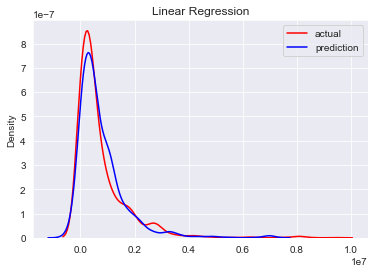

2nd Degree Polynomial Regression
R-Squared: 0.894693
MAE: 197183.564294
RMSE: 325053.979894


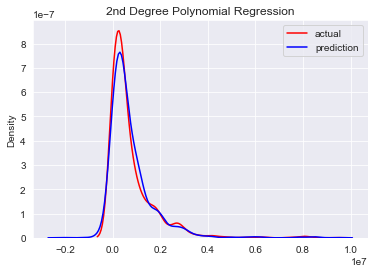

Decision Tree - Max Depth 2
R-Squared: 0.620634
MAE: 361208.437348
RMSE: 616958.568209
Decision Tree - Max Depth 5
R-Squared: 0.874995
MAE: 198920.093860
RMSE: 354152.901365


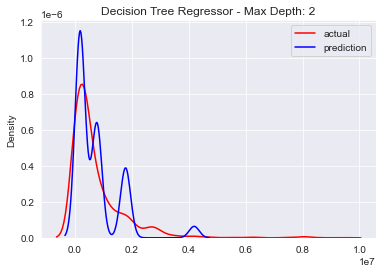

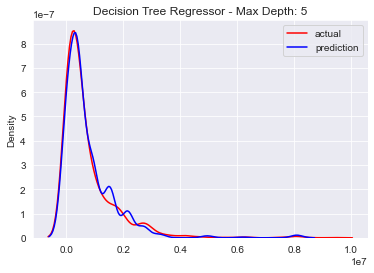

(0.8749948438843105, 198920.0938604466)

In [363]:
# Overall Model - all features

LR(X_train, X_test, y_train, y_test)
PR(X_train, X_test, y_train, y_test)
DT(X_train, X_test, y_train, y_test)

### Feature Selection

In [364]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

def select_features(X_train, y_train, X_test, k):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

video_duration: 22.594173
authorStats_diggCount: 11.560298
authorStats_followingCount: 150.854634
authorStats_followerCount: 406.084694
authorStats_heartCount: 67.528831
stats_playCount: 48586.145324
authorStats_videoCount: 1.481212
duetEnabled: 9.442920
stitchEnabled: 0.180288
shareEnabled: nan
stats_shareCount: 1275.948567
stats_commentCount: 17610.777746
music_original: 9.415596
scrape_date: 77.512896
scrape_week: 80.406973
daysFromPost: 1183.798660
0: 93.169084
1: 21.749977
2: 41.468992
3: 55.991810
4: 164.645110
5: 35.739892
6: 187.244112
7: 113.086797
8: 1.350388
9: 80.567904
10: 119.454939
11: 0.301022
12: 800.519691
13: 67.601237
14: 0.935239
15: 77.061568
16: 29.534511
17: 8.988603
18: 64.170821
19: 10.050103
20: 66.923879
21: 80.655422
22: 106.030906
23: 29.388423
24: 96.373065


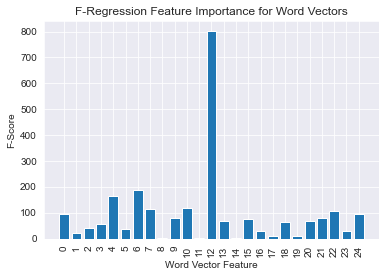

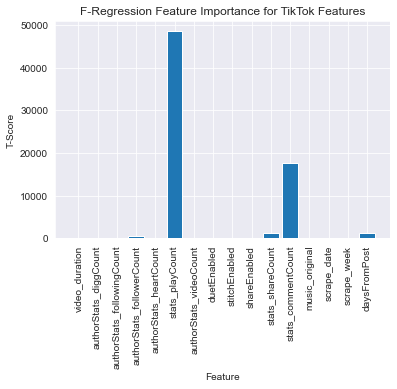

In [386]:
X_train_fs_1, X_test_fs_1, fs_1 = select_features(X_train, y_train, X_test, 15)

# what are scores for the features
for i in range(len(fs_1.scores_)):
    print('%s: %f' % ([df_allfeat.drop('stats_diggCount', axis='columns').columns[i] for i in range(len(fs_1.scores_))][i], fs_1.scores_[i]))
# plot the scores

plt.bar([df_allfeat.drop('stats_diggCount', axis='columns').columns[i] for i in range(len(fs_1.scores_))][16:], fs_1.scores_[16:])
plt.xticks(rotation=90)
plt.xlabel("Word Vector Feature")
plt.ylabel("F-Score")
plt.title("F-Regression Feature Importance for Word Vectors")
plt.show()

plt.bar([df_allfeat.drop('stats_diggCount', axis='columns').columns[i] for i in range(len(fs_1.scores_))][:16], fs_1.scores_[:16])
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("F-Score")
plt.title("F-Regression Feature Importance for TikTok Features")
plt.show()

In [374]:
def feature_opt(X_train, y_train, X_test, y_test):

    lr_r = list()
    lr_mae = list()
    pr_r = list()
    pr_mae = list()
    dt_r = list()
    dt_mae = list()
    il = list()

    for i in range(5,35):
        X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, i)
        lscore, lmae = LR(X_train_fs, X_test_fs, y_train, y_test, s=1)
        pscore, pmae = PR(X_train_fs, X_test_fs, y_train, y_test, s=1)
        dscore, dmae = DT(X_train_fs, X_test_fs, y_train, y_test, s=1)

        lr_r.append(lscore)
        lr_mae.append(lmae)
        pr_r.append(pscore)
        pr_mae.append(pmae)
        dt_r.append(dscore)
        dt_mae.append(dmae)
        il.append(i)

    sns.set_style("darkgrid")
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(15, 5.5)

    sns.lineplot(ax=axs[0], x=il, y=lr_r, color = 'r', label = 'Linear Regression')
    sns.lineplot(ax=axs[1], x=il, y=lr_mae, color = 'r', label = 'Linear Regression')
    sns.lineplot(ax=axs[0], x=il, y=pr_r, color = 'b', label = '2nd Degree Polynomial')
    sns.lineplot(ax=axs[1], x=il, y=pr_mae, color = 'b', label = '2nd Degree Polynomial')
    sns.lineplot(ax=axs[0], x=il, y=dt_r, color = 'g', label = 'Decision Tree')
    sns.lineplot(ax=axs[1], x=il, y=dt_mae, color = 'g', label = 'Decision Tree')
    
    axs[0].title.set_text('R-Squared Values')
    axs[1].title.set_text('Mean Absolute Error (MAE) Values')
    axs[0].set(xlabel='Number of Most Important Features', ylabel='R-Squared')
    axs[1].set(xlabel='Number of Most Important Features', ylabel='MAE')
    

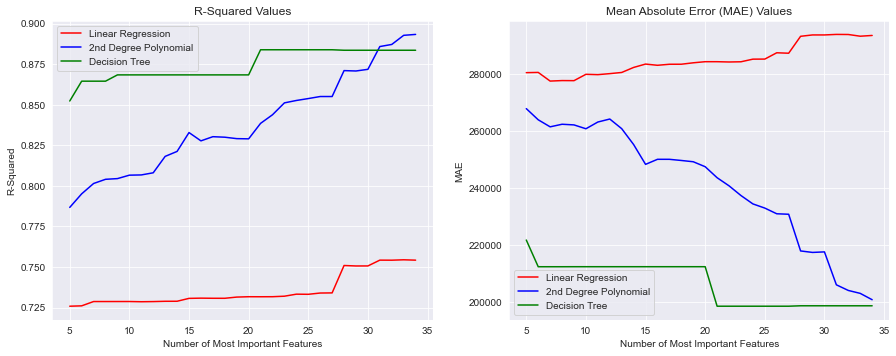

In [366]:
feature_opt(X_train, y_train, X_test, y_test)

### Split Verified vs. Non-verified

In [367]:
df_v = df_allfeat_v[df_allfeat_v['author_verified'] == True]
df_nonv = df_allfeat_v[df_allfeat_v['author_verified'] == False]

print(df_v.shape)
print(df_nonv.shape)

(3688, 44)
(17754, 44)


### Verified Users

In [368]:
X_v = df_v.astype(int).drop(['stats_diggCount', 'sentiment'], axis='columns')
y_v = df_v[['stats_diggCount']]

In [369]:
scaler_x = MinMaxScaler(feature_range = (0,1))

sc_X = StandardScaler()
X_v = scaler_x.fit_transform(X_v)

In [370]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_v, y_v, test_size=0.10, random_state=42)

Linear Regression
R-Squared: 0.867651
MAE: 170909.262140
RMSE: 275185.275590


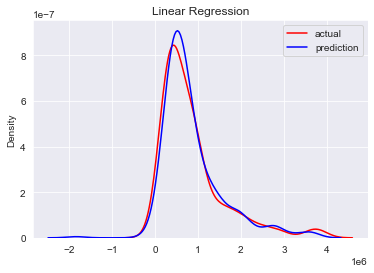

2nd Degree Polynomial Regression
R-Squared: -47557.723501
MAE: 8911167.234623
RMSE: 164960498.365115


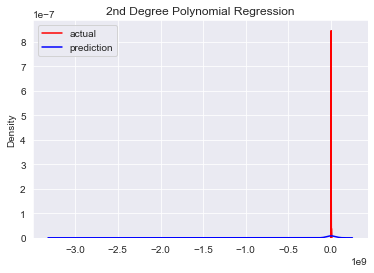

Decision Tree - Max Depth 2
R-Squared: 0.786702
MAE: 246395.617187
RMSE: 349348.189671
Decision Tree - Max Depth 5
R-Squared: 0.960795
MAE: 100743.321344
RMSE: 149774.615318


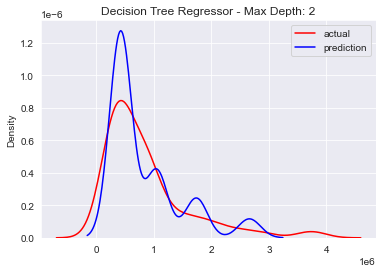

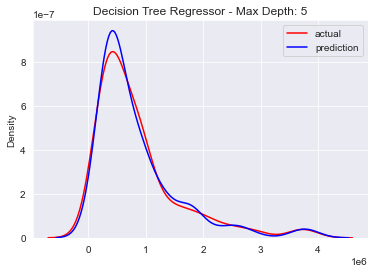

(0.9607945272488144, 100743.32134350414)

In [371]:
LR(X_train_v, X_test_v, y_train_v, y_test_v)
PR(X_train_v, X_test_v, y_train_v, y_test_v)
DT(X_train_v, X_test_v, y_train_v, y_test_v)

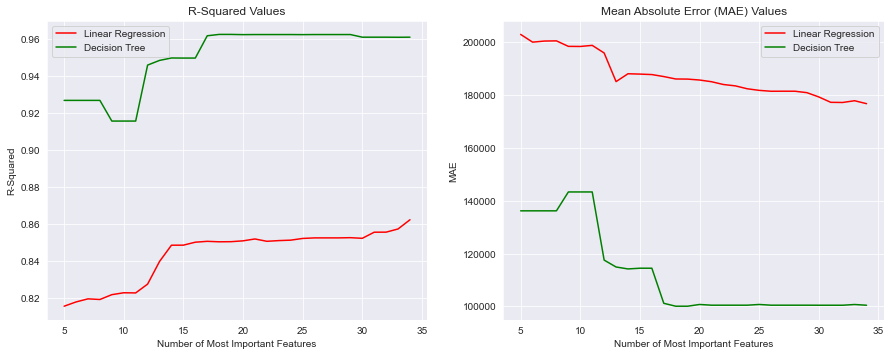

In [373]:
feature_opt(X_train_v, y_train_v, X_test_v, y_test_v)

Feature video_duration: 74.622561
Feature authorStats_diggCount: 5.860040
Feature authorStats_followingCount: 25.305798
Feature authorStats_followerCount: 63.821922
Feature authorStats_heartCount: 17.075856
Feature stats_playCount: 8859.839294
Feature authorStats_videoCount: 103.945740
Feature duetEnabled: 13.299377
Feature stitchEnabled: 8.150008
Feature author_verified: nan
Feature shareEnabled: nan
Feature stats_shareCount: 1851.285754
Feature stats_commentCount: 1107.102985
Feature music_original: 137.681947
Feature scrape_date: 82.286610
Feature scrape_week: 84.223769
Feature daysFromPost: 48.190597
Feature sentiment: nan
Feature 0: 5.265016
Feature 1: 5.844114
Feature 2: 10.287516
Feature 3: 2.708525
Feature 4: 47.581629
Feature 5: 1.862680
Feature 6: 5.196743
Feature 7: 0.001280
Feature 8: 10.857352
Feature 9: 2.723327
Feature 10: 256.167648
Feature 11: 9.893272
Feature 12: 13.417952
Feature 13: 1.138519
Feature 14: 23.893080
Feature 15: 0.276081
Feature 16: 11.687722
Feature 17

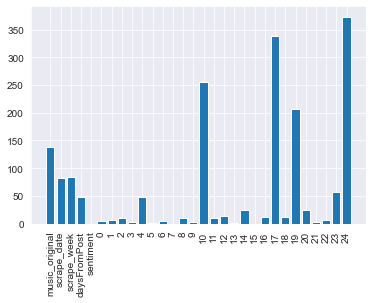

In [403]:
# Verified Feature Importance

X_train_fs_v_s, X_test_fs_v_s, fs_v_s = select_features(X_train_v_s, y_train_v_s, X_test_v_s, 15)

# what are scores for the features
for i in range(len(fs_v_s.scores_)):
    print('Feature %s: %f' % (df_v.drop('stats_diggCount', axis='columns').columns[i], fs_v_s.scores_[i]))
# plot the scores
plt.bar([df_v.drop('stats_diggCount', axis='columns').columns[i] for i in range(len(fs_v_s.scores_))][13:], fs_v_s.scores_[13:])
plt.xticks(rotation=90)
plt.show()

### Non-Verified Users

In [375]:
X_nv = df_nonv.astype(int).drop(['stats_diggCount', 'sentiment'], axis='columns')
y_nv = df_nonv[['stats_diggCount']]

In [376]:
scaler_x = MinMaxScaler(feature_range = (0,1))

sc_X = StandardScaler()
X_nv = scaler_x.fit_transform(X_nv)

In [377]:
X_train_nv, X_test_nv, y_train_nv, y_test_nv = train_test_split(X_nv, y_nv, test_size=0.10, random_state=42)

Linear Regression
R-Squared: 0.802212
MAE: 290248.135238
RMSE: 471669.463734


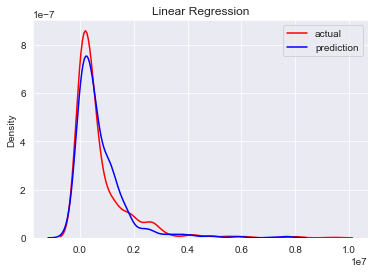

2nd Degree Polynomial Regression
R-Squared: 0.913243
MAE: 187618.079141
RMSE: 312384.012111


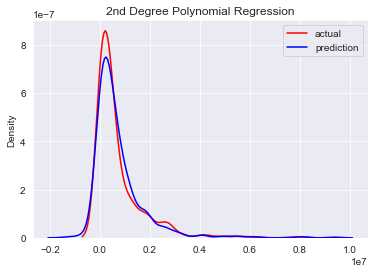

Decision Tree - Max Depth 2
R-Squared: 0.686604
MAE: 352284.479567
RMSE: 593723.384867
Decision Tree - Max Depth 5
R-Squared: 0.919254
MAE: 169681.323091
RMSE: 301369.446349


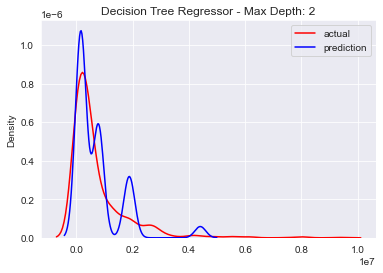

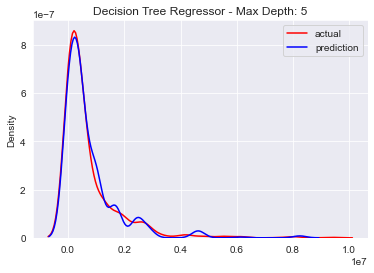

(0.9192536093907191, 169681.32309074947)

In [378]:
LR(X_train_nv, X_test_nv, y_train_nv, y_test_nv)
PR(X_train_nv, X_test_nv, y_train_nv, y_test_nv)
DT(X_train_nv, X_test_nv, y_train_nv, y_test_nv)

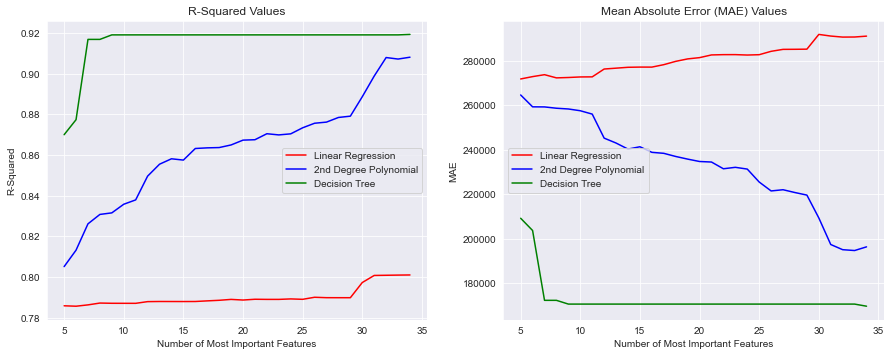

In [379]:
feature_opt(X_train_nv, y_train_nv, X_test_nv, y_test_nv)

Feature video_duration: 1.870227
Feature authorStats_diggCount: 13.240744
Feature authorStats_followingCount: 126.181850
Feature authorStats_followerCount: 523.723747
Feature authorStats_heartCount: 404.922794
Feature stats_playCount: 40342.115315
Feature authorStats_videoCount: 18.176974
Feature duetEnabled: 8.495632
Feature stitchEnabled: 0.286111
Feature author_verified: nan
Feature shareEnabled: nan
Feature stats_shareCount: 879.609745
Feature stats_commentCount: 20285.620808
Feature music_original: 0.252947
Feature scrape_date: 43.018553
Feature scrape_week: 45.647953
Feature daysFromPost: 1193.457052
Feature sentiment: 90.386116
Feature 0: 15.482291
Feature 1: 30.398800
Feature 2: 51.857891
Feature 3: 122.207483
Feature 4: 31.862369
Feature 5: 221.248444
Feature 6: 119.603593
Feature 7: 1.209435
Feature 8: 77.965626
Feature 9: 69.141637
Feature 10: 0.027372
Feature 11: 794.032315
Feature 12: 55.692250
Feature 13: 2.684239
Feature 14: 67.246327
Feature 15: 39.079331
Feature 16: 0.

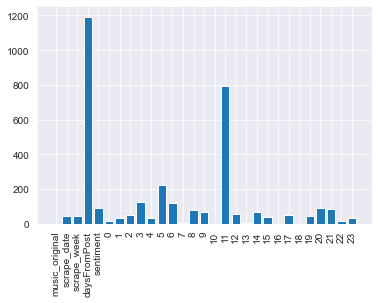

In [384]:
# Unverified Feature Importance
X_train_fs_nv_s, X_test_fs_nv_s, fs_nv_s = select_features(X_train_nv, y_train_nv, X_test_nv, 15)

# what are scores for the features
for i in range(len(fs_nv_s.scores_)):
    print('Feature %s: %f' % (df_v.drop('stats_diggCount', axis='columns').columns[i], fs_nv_s.scores_[i]))
# plot the scores
plt.bar([df_nonv.drop('stats_diggCount', axis='columns').columns[i] for i in range(len(fs_nv_s.scores_))][13:], fs_nv_s.scores_[13:])
plt.xticks(rotation=90)
plt.show()